# 1. data preparation

## 1.1 download dataset

In [ ]:
# install kaggle api for downloading kaggle dataset
! pip install kaggle

In [ ]:
# make a directory name 'kaggle' for this project
! mkdir ~/.kaggle

In [ ]:
# copy a file 'kaggle.json' to the kaggle directory
! cp kaggle.json ~/.kaggle/

In [ ]:
# allocate the required permission from kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download dataset from:
# https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia/download
! kaggle datasets download prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:21<00:00, 57.8MB/s]
100% 2.06G/2.06G [00:21<00:00, 103MB/s] 


In [ ]:
# unzip the dataset
! unzip chest-xray-covid19-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/train/COVID19/COVID19(228).jpg  
  inflating: Data/train/COVID19/COVID19(229).jpg  
  inflating: Data/train/COVID19/COVID19(23).jpg  
  inflating: Data/train/COVID19/COVID19(230).jpg  
  inflating: Data/train/COVID19/COVID19(231).jpg  
  inflating: Data/train/COVID19/COVID19(232).jpg  
  inflating: Data/train/COVID19/COVID19(233).jpg  
  inflating: Data/train/COVID19/COVID19(234).jpg  
  inflating: Data/train/COVID19/COVID19(235).jpg  
  inflating: Data/train/COVID19/COVID19(236).jpg  
  inflating: Data/train/COVID19/COVID19(237).jpg  
  inflating: Data/train/COVID19/COVID19(238).jpg  
  inflating: Data/train/COVID19/COVID19(239).jpg  
  inflating: Data/train/COVID19/COVID19(24).jpg  
  inflating: Data/train/COVID19/COVID19(240).jpg  
  inflating: Data/train/COVID19/COVID19(241).jpg  
  inflating: Data/train/COVID19/COVID19(242).jpg  
  inflating: Data/train/COVID19/COVID19(243).jpg  
  inflating: Data/train/COVID19/C

## 1.2 visualize train and test images 

In [ ]:
# train and test preparation
import os  # to list files in folders
import matplotlib.pyplot as plt  # to plot graph

TrainImage = 'Data/train/'  # train folder
TestImage = 'Data/test/'  # test folder

#plot images
def imagePlot(target_string):
  '''
    plot images of 3 classes in train dataset
    Input:
      target_string: string of the target image folder
    Output:
      none
  '''
  plt.figure(figsize=(20,10))  # define figure size
  for i in range(6):  # plot 6 images
    plt.subplot(3, 3, i + 1)  # create a subplot
    # plot an image
    plt.imshow(plt.imread(os.path.join(TrainImage + target_string,
                                       os.listdir(TrainImage + target_string)[i])),cmap='gray')
    plt.title(target_string[1:])  # define title
    
  plt.show()  # show all plots

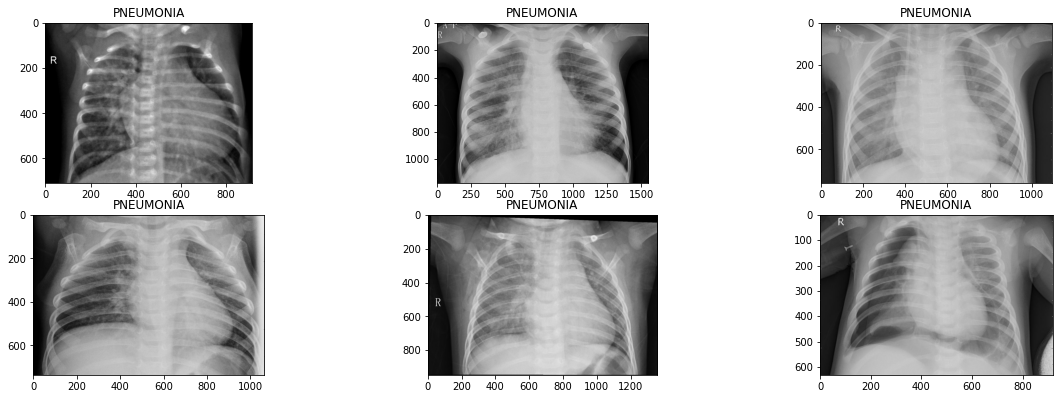

In [ ]:
# show PNEUMONIA images
imagePlot("/PNEUMONIA")

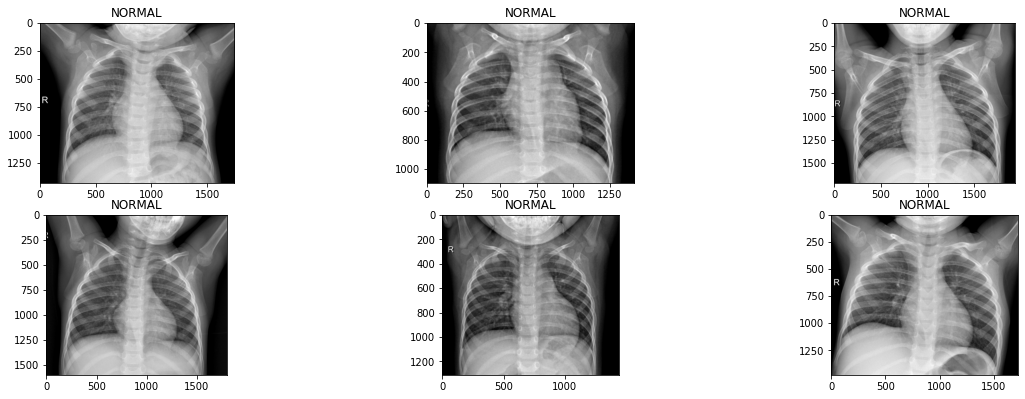

In [ ]:
# show NORMAL images
imagePlot("/NORMAL")

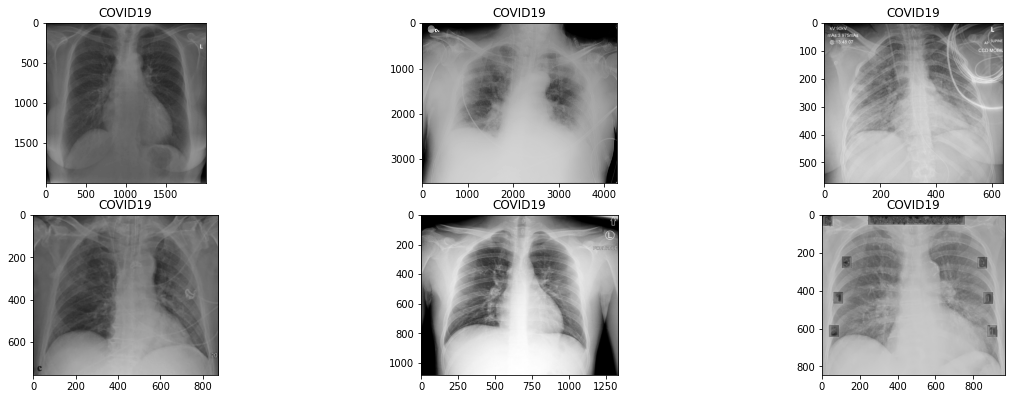

In [ ]:
# show COVID19 images
imagePlot("/COVID19")

## 1.3 images augmentation

In [ ]:
# perform images augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # to perform images augmentation

# images augmentation configuration
train_datagen = ImageDataGenerator(
      samplewise_center=True,  # center the images
      samplewise_std_normalization= True,  # normalize the images
      width_shift_range=0.2,  # shift the images by width
      height_shift_range=0.2,  # shift the images by height
      shear_range=45,  # generate shear angles
      zoom_range=0.2,  # images zooming
      rotation_range=20,  # images rotating
                                  )

# generate train dataset
train_generator =train_datagen.flow_from_directory(
     TrainImage,  # train folder
     batch_size = 10,  # define batch size
     shuffle=True,  # shuffle the train dataset
     target_size=(300, 300)  # define target output images size

)

# generate test dataset
test_generator =train_datagen.flow_from_directory(
     TestImage,  # test folder
     batch_size= 1,  # define batch size (1 for test dataset)
     shuffle=False,  # don't need to shuffle test dataset
     target_size=(300, 300)  # define target output images size

)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
# shape of dataset
trainShape=train_generator.__getitem__(0)[0].shape  # train shape
testShape=test_generator.__getitem__(0)[0].shape  # test shape
print("Train Shape \n",trainShape)
print("Test Shape \n",testShape)

Train Shape 
 (256, 300, 300, 3)
Test Shape 
 (1, 300, 300, 3)


In [ ]:
# function to map between class names and numbers
Labels={'NORMAL':0,'PNEUMONIA':1,'COVID19':2}  # dictionary for mapping

def getInt(label):
  '''
    generate int from class name
  '''
  return Labels[label]

def getClassName(n):
  '''
    generate class name from int
  '''
  for x,c in Labels.items():
    if n==c:
      return x
       
print(getInt('COVID19'))
print(getClassName(1))

2
PNEUMONIA


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


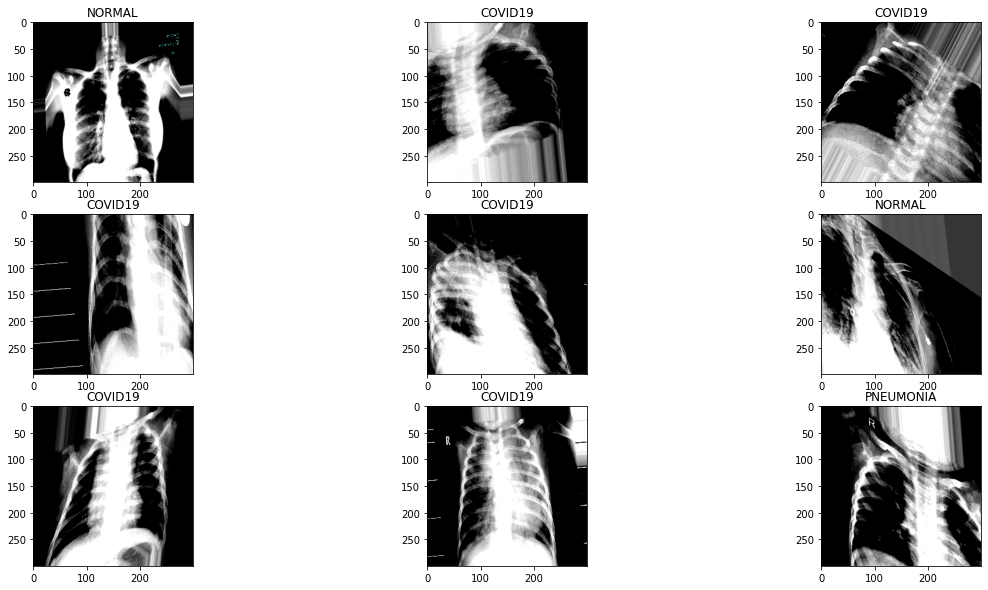

In [ ]:
# show images after augmentation
import numpy as np  # for calculating numeric values
plt.figure(figsize=(20,10))  # define figure size
for i in range(9):  # show 9 images
    plt.subplot(3, 3, i + 1)  # define a subplot
    plt.imshow(train_generator.__getitem__(0)[0][i])  # show an image
    plt.title(getClassName(np.argmax(train_generator.__getitem__(0)[1][i])))  # define title

# 2. pre-trained models

## 2.1 train and evaluation functions

In [ ]:
from tensorflow.keras.applications import VGG16  # VGG16 pre-trained model
from tensorflow.keras.applications import ResNet50V2  # resnet50v2 pre-trained model
import tensorflow as tf  # for deep learning
from tensorflow.keras import Model  # for creating a model
from sklearn.metrics import confusion_matrix, classification_report  # for calculating precision, recall, f1-score, and accuracy
import pandas as pd  # for creating a table
import numpy as np  # for calculating numeric values

def pretrained_model(model):
  '''
    Create a model from a pre-trained model by adding 1 3-nodes dense layer on top
    of the model
    Input:
      model: a pre-trained model
    Output:
      a model 
  '''
  # define a pre-trained model without the top layers, and with the default weights
  pre_trained_model = model(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')
  pre_trained_model.trainable = False  # freeze the weights
  pre_trained_model.summary()

  x = tf.keras.layers.Flatten()(pre_trained_model.output)  # flatten layer
  x = tf.keras.layers.Dense(3 , activation='sigmoid')(x)  # 1 3-nodes dense layer
  model = Model(pre_trained_model.input, x) 
  model.summary()

  return model

def train(model):
  '''
    train the model
    Input:
      model: a model
    Output:
      history of the training process
  '''
  # compile the model with specific configuration
  model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])
  # train the model for 10 epochs and 30 steps for each epoch
  history = model.fit(train_generator, epochs = 10, steps_per_epoch = 30)
  return history

def plot_train_evaluation(history, model):
  '''
    Plot train loss and acuracy. Then, evaluate the model (precision, recall, f1-score, and accuracy) with test dataset
    Input:
      history: a history of the training process
      model: a model
    Output:
      test report (DataFrame)
  '''
  # train loss and accuracy plot
  plt.figure(figsize=(12, 8))  # define figure size
  plt.subplot(2, 2, 1)  # create a subplot
  plt.plot(history.history['loss'], label='Loss')  # loss plot
  plt.legend()  # plot legend
  plt.xlabel('epochs')  # define x label
  plt.title('Loss plot')  # define title

  plt.subplot(2, 2, 2)  # create a subplot
  plt.plot(history.history['accuracy'], label='Accuracy')  # accuracy plot
  plt.legend()  # plot legend
  plt.xlabel('epochs')  # define x label
  plt.title('Accuracy plot')  # define title
  plt.show()  # show all plots

  # print out average, max, and min of train accuracy and loss
  print('average train accuracy: ', sum(history.history['accuracy'])/len(history.history['accuracy']))
  print('max train accuracy: ', max(history.history['accuracy']))
  print('average train loss: ', sum(history.history['loss'])/len(history.history['loss']))
  print('min train loss: ', min(history.history['loss']))

  # model evaluation
  evaluation = model.evaluate(test_generator)
  print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")  # print test accuracy
  pred=model.predict(test_generator)  # prediction values
  pred= np.argmax(pred,axis=1)  # get the class numbers
  target_names = ['NORMAL', 'PNEUMONIA', 'COVID19']  # class names
  return pd.DataFrame(classification_report(test_generator.classes, pred, target_names=target_names, output_dict=True))  # test report


## 2.2 VGG16

In [ ]:
# VGG16 pre-trained model
model1 = pretrained_model(VGG16)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
# train the model
history1 = train(model1)

Epoch 1/10
30/30 [==============================] - 16s 499ms/step - loss: 0.7246 - accuracy: 0.6900
Epoch 2/10
30/30 [==============================] - 15s 496ms/step - loss: 0.3241 - accuracy: 0.8000
Epoch 3/10
30/30 [==============================] - 15s 491ms/step - loss: 0.3533 - accuracy: 0.8133
Epoch 4/10
30/30 [==============================] - 15s 493ms/step - loss: 0.2498 - accuracy: 0.8600
Epoch 5/10
30/30 [==============================] - 16s 520ms/step - loss: 0.2208 - accuracy: 0.8600
Epoch 6/10
30/30 [==============================] - 15s 511ms/step - loss: 0.2623 - accuracy: 0.8500
Epoch 7/10
30/30 [==============================] - 16s 526ms/step - loss: 0.2364 - accuracy: 0.8600
Epoch 8/10
30/30 [==============================] - 15s 491ms/step - loss: 0.2420 - accuracy: 0.8600
Epoch 9/10
30/30 [==============================] - 16s 538ms/step - loss: 0.2552 - accuracy: 0.8600
Epoch 10/10
30/30 [==============================] - 15s 497ms/step - loss: 0.2675 - accura

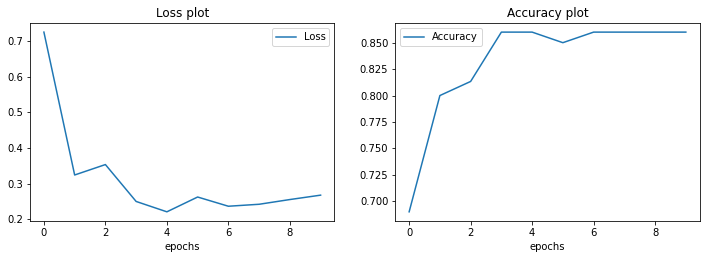

average train accuracy:  0.8313333451747894
max train accuracy:  0.8600000143051147
average train loss:  0.3136019244790077
min train loss:  0.22081007063388824
1288/1288 [==============================] - 83s 64ms/step - loss: 0.3261 - accuracy: 0.8323
Test Accuracy: 83.23%


,NORMAL,PNEUMONIA,COVID19,accuracy,macro avg,weighted avg
precision,0.788732,0.635983,0.983533,0.833075,0.802750,0.880451
recall,0.965517,0.958991,0.768421,0.833075,0.897643,0.833075
f1-score,0.868217,0.764780,0.862771,0.833075,0.831923,0.839144
support,116.000000,317.000000,855.000000,0.833075,1288.000000,1288.000000


In [ ]:
# training and testing results
plot_train_evaluation(history1, model1)

## 2.3 resnet50v2

In [ ]:
# pre-trained model
model2 = pretrained_model(ResNet50V2)

94683136/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
# train the model
history2 = train(model2)

Epoch 1/10
30/30 [==============================] - 58s 459ms/step - loss: 14.0419 - accuracy: 0.5933
Epoch 2/10
30/30 [==============================] - 16s 521ms/step - loss: 12.1573 - accuracy: 0.6467
Epoch 3/10
30/30 [==============================] - 15s 500ms/step - loss: 8.9870 - accuracy: 0.7133
Epoch 4/10
30/30 [==============================] - 14s 472ms/step - loss: 6.5447 - accuracy: 0.7400
Epoch 5/10
30/30 [==============================] - 15s 491ms/step - loss: 6.2308 - accuracy: 0.7300
Epoch 6/10
30/30 [==============================] - 14s 473ms/step - loss: 6.9712 - accuracy: 0.7500
Epoch 7/10
30/30 [==============================] - 15s 490ms/step - loss: 7.1624 - accuracy: 0.7867
Epoch 8/10
30/30 [==============================] - 14s 461ms/step - loss: 6.8219 - accuracy: 0.7767
Epoch 9/10
30/30 [==============================] - 14s 468ms/step - loss: 5.4669 - accuracy: 0.8433
Epoch 10/10
30/30 [==============================] - 14s 470ms/step - loss: 7.3522 - accu

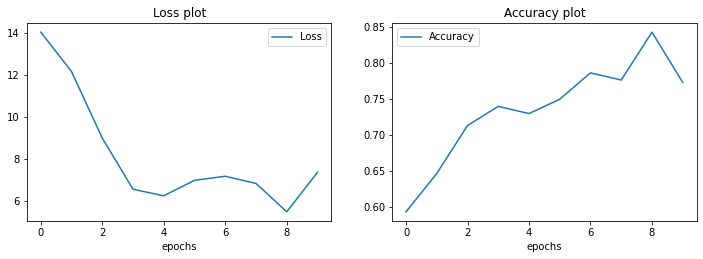

average train accuracy:  0.7353333234786987
max train accuracy:  0.8433333039283752
average train loss:  8.173634719848632
min train loss:  5.466867446899414
1288/1288 [==============================] - 74s 56ms/step - loss: 6.2719 - accuracy: 0.8106
Test Accuracy: 81.06%


,NORMAL,PNEUMONIA,COVID19,accuracy,macro avg,weighted avg
precision,0.773585,0.721239,0.812762,0.793478,0.769195,0.786708
recall,0.706897,0.514196,0.908772,0.793478,0.709955,0.793478
f1-score,0.738739,0.600368,0.858089,0.793478,0.732399,0.783911
support,116.000000,317.000000,855.000000,0.793478,1288.000000,1288.000000


In [ ]:
# training and testing results
plot_train_evaluation(history2, model2)

# 3. Improve the previous VGG16

## 3.1 train added layers

In [ ]:
# generate the model with batch normalization and dropout

# base model = pre-trained VGG16, without top layers, and with default weights
base_model = VGG16(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False  # freeze the weights

# layer no 19
x = tf.keras.layers.Flatten()(base_model.output)  # flatten layer
x = tf.keras.layers.BatchNormalization(axis=1)(x)  # batch normalization layer
x = tf.keras.layers.Dropout(0.3)(x)  # dropout layer
x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)  # 3 nodes dense layer
model_alternative = Model(base_model.input, x) 
model_alternative.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0  

In [ ]:
# batch normalization layer (layer no 20)
model_alternative.layers[20]

In [ ]:
# train added layers, freeze the batch normalization layer
print("Number of layers in the base model: ", len(model_alternative.layers))  # numbers of layers
batch_narmalization_layer = [20]  # list of batch normalization layers
for target_layer in batch_narmalization_layer:
  model_alternative.layers[target_layer].trainable = False  # freeze the batch normalization layer's weights
model_alternative.summary()

Number of layers in the base model:  23
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxP

In [ ]:
# train the model

from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping  # for learning rate reduction and early stopping
lr_reduce = ReduceLROnPlateau(monitor='accuracy', patience=1)  # learning rate reduction
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)  # early stopping
initial_epochs = 10  # initial epochs

# compile the model with specific configuration
model_alternative.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])

# train the model with 10 epochs, 30 steps per epoch, and with learning rate reduction as well as early stopping
history3 = model_alternative.fit(train_generator, epochs=initial_epochs, steps_per_epoch = 30, callbacks=[lr_reduce, early_stop])

Epoch 1/10
30/30 [==============================] - 16s 505ms/step - loss: 0.6783 - accuracy: 0.6667 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 15s 493ms/step - loss: 0.3483 - accuracy: 0.7900 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 15s 495ms/step - loss: 0.2848 - accuracy: 0.8400 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 15s 495ms/step - loss: 0.2910 - accuracy: 0.8133 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 15s 496ms/step - loss: 0.2813 - accuracy: 0.8333 - lr: 1.0000e-04
Epoch 6/10
30/30 [==============================] - 15s 486ms/step - loss: 0.2138 - accuracy: 0.8800 - lr: 1.0000e-05
Epoch 7/10
30/30 [==============================] - 15s 497ms/step - loss: 0.2324 - accuracy: 0.8733 - lr: 1.0000e-05
Epoch 8/10
30/30 [==============================] - 15s 494ms/step - loss: 0.2601 - accuracy: 0.8467 - lr: 1.0000e-06
Epoch 9/10
30/30 [==============================] - 15s 504ms/step - los

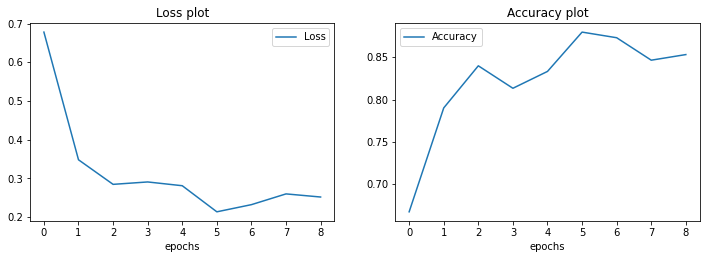

average train accuracy:  0.8218518561787076
max train accuracy:  0.8799999952316284
average train loss:  0.31578686005539364
min train loss:  0.21383529901504517
1288/1288 [==============================] - 81s 63ms/step - loss: 0.2069 - accuracy: 0.8773
Test Accuracy: 87.73%


,NORMAL,PNEUMONIA,COVID19,accuracy,macro avg,weighted avg
precision,0.925532,0.799363,0.903409,0.879658,0.876101,0.879794
recall,0.750000,0.791798,0.929825,0.879658,0.823874,0.879658
f1-score,0.828571,0.795563,0.916427,0.879658,0.846854,0.878767
support,116.000000,317.000000,855.000000,0.879658,1288.000000,1288.000000


In [ ]:
# training and testing results
plot_train_evaluation(history3, model_alternative)

## 3.2 fine-tune the layers inside VGG16 

In [ ]:
# freeze weights in defined layers

fine_tune_epochs = 10  # numbers of added epochs
total_epochs =  initial_epochs + fine_tune_epochs  # maximum epochs to be trained
fine_tune_at = 15  # defined layers to be fine-tune onwards
base_model.trainable = True  # unfreeze all layers in base model

# freeze all the layers before the layer number 15
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# freeze added layers which are already trained before
for layer in model_alternative.layers[19:]:
  layer.trainable = False
model_alternative.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0  

In [ ]:
# continue to train the model with total_epochs epochs, 30 steps per epoch
# and with learning rate reduction and early stopping
history_fine = model_alternative.fit(train_generator,
                         epochs=total_epochs,
                         steps_per_epoch = 30,
                         initial_epoch=history3.epoch[-1],
                         callbacks=[lr_reduce, early_stop])

Epoch 9/20
30/30 [==============================] - 14s 476ms/step - loss: 0.2002 - accuracy: 0.8933 - lr: 1.0000e-08
Epoch 10/20
30/30 [==============================] - 15s 501ms/step - loss: 0.2170 - accuracy: 0.8667 - lr: 1.0000e-08
Epoch 11/20
30/30 [==============================] - 15s 495ms/step - loss: 0.1857 - accuracy: 0.8967 - lr: 1.0000e-09
Epoch 12/20
30/30 [==============================] - 15s 491ms/step - loss: 0.2090 - accuracy: 0.9100 - lr: 1.0000e-09
Epoch 13/20
30/30 [==============================] - 15s 493ms/step - loss: 0.2365 - accuracy: 0.8600 - lr: 1.0000e-09
Epoch 14/20
30/30 [==============================] - 16s 535ms/step - loss: 0.2396 - accuracy: 0.8800 - lr: 1.0000e-10
Epoch 15/20
30/30 [==============================] - 15s 494ms/step - loss: 0.2102 - accuracy: 0.8667 - lr: 1.0000e-11


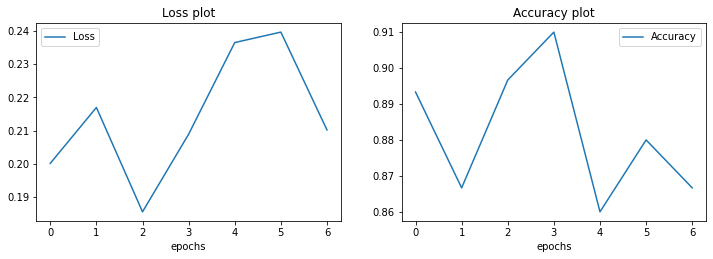

average train accuracy:  0.8819047638348171
max train accuracy:  0.9100000262260437
average train loss:  0.2140301593712398
min train loss:  0.18567925691604614
1288/1288 [==============================] - 81s 63ms/step - loss: 0.2091 - accuracy: 0.8913
Test Accuracy: 89.13%


,NORMAL,PNEUMONIA,COVID19,accuracy,macro avg,weighted avg
precision,0.963855,0.794212,0.893736,0.874224,0.883935,0.875557
recall,0.689655,0.779180,0.934503,0.874224,0.801113,0.874224
f1-score,0.804020,0.786624,0.913665,0.874224,0.834770,0.872523
support,116.000000,317.000000,855.000000,0.874224,1288.000000,1288.000000


In [ ]:
# training and testing results
plot_train_evaluation(history_fine, model_alternative)